# Lecture 8 - HMMs

## 2021/05/26

## Gene 111

## Logistics

- Homework 5 due today

- Homework regrades for 1-5 possible up until Monday

- Homework 6 out today, due Monday

- Friday is last class

## Hidden states are everywhere

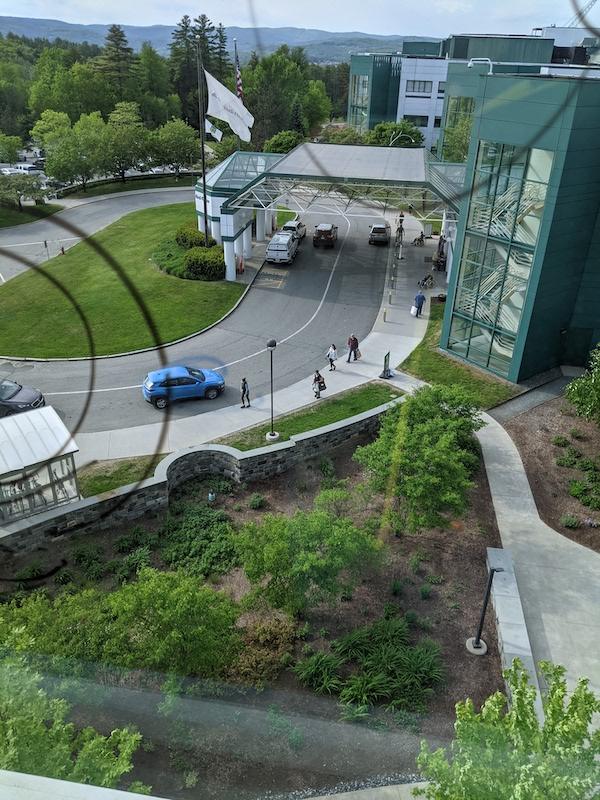

## Back to our crooked dealer

- Somehow you can see transition and emission matrices right there on the table

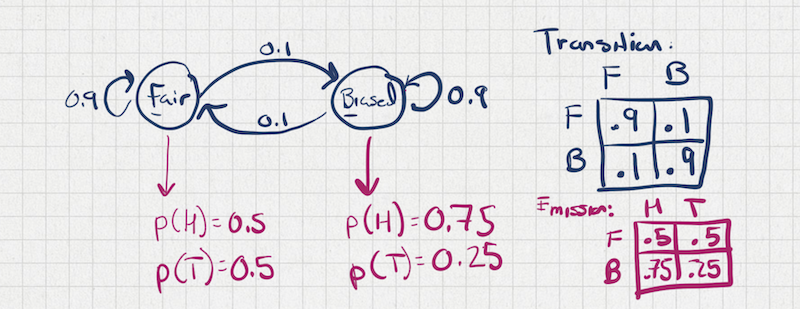

## Now let's imagine a we're observing the coin flips

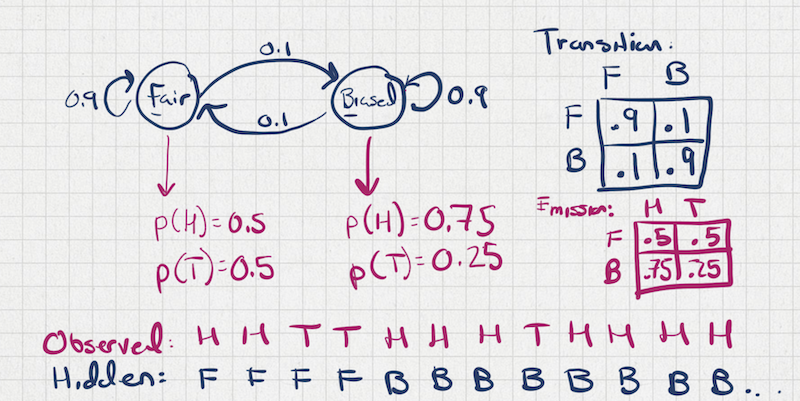

## We can assign individual probabilities from each matrix

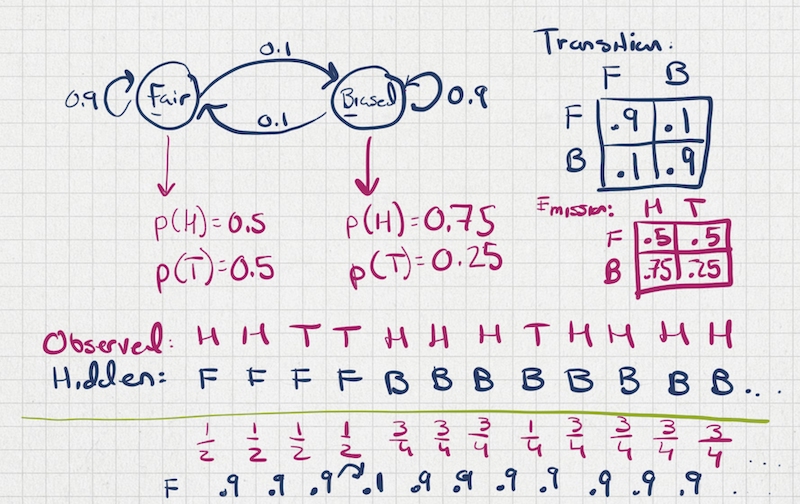

## But hidden states are, well, hidden

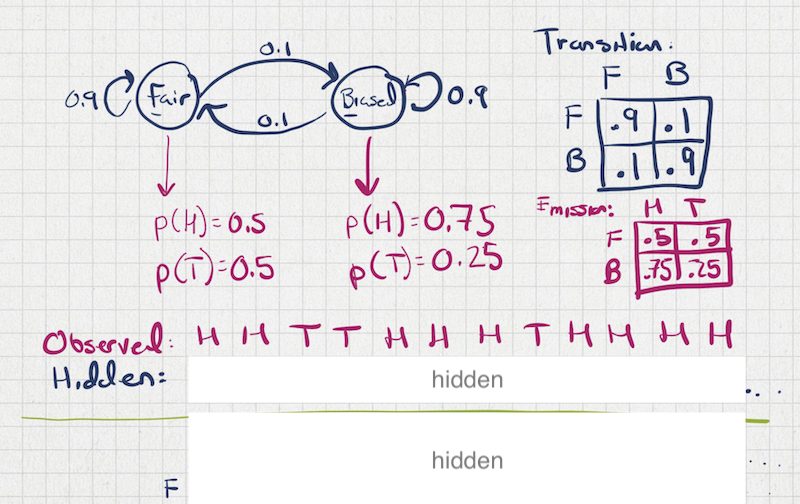

<h1><center>So how do we find out the hidden states? </center></h1>


## What we know

1) We know that transitions from all possible states _l_ to _k_ must sum to one:
    
<center>$ \sum\limits_{\text{all states } \pi} \text{transitions}_{l,k} = 1$</center>


2) We know that all the emissions, given the state, must sum to 1:

<center>$ \sum\limits_{\text{all emission symbols f}} \text{emission}_{l}(f) = 1$</center>


3) All possible paths must sum to 1:

<center>$ \sum\limits_{\text{all states }\pi \text{ and }} \sum\limits_{\text{all emission symbols f}} P(f,\pi) = 1$</center>


## Probabilities

For any one path through the hidden states and emissions, we first choose a state:

state $ = P(\pi)$

Then we choose an emission based on that state:

emission = $ P(f | \pi)$

So to both follow a state path and emit a symbol the probability is:

$ P(x, \pi) = P(\pi) * P(f | \pi)$


## So what?

- What do we actually want to do?

- We want to know the best (highest probability) path over all hidden states and emissions for our data

- Decoding problem: finding this the optimal path

- BUT HOW? Thanks to Andrew Viterbi we can...

## Solve the decoding problem with the Viterbi algorithm

- We want to enumerate out this model over __all__ posititions in our list of coin flips

- We borrow a similar approach from our sequence alignment dynamic programming, remembering the best solution 

- The best solution is easy to solve from the previous best solution and our emission state

- We can then make a recurrance relationship:

<center>$P(\pi_x,f_x) = P(f_x | \pi_x) * P(\pi_{x-1} \text{ to } \pi_{x})$</center>

- In Viterbi we store the maximum score path at each internal node:

<center>$P(\pi_x,f_x) = \text{max}_{i}\text{ for all } i \text{ in } ( 
P(f_x | \pi_{x_{i}}) * P(\pi_{{x_i}-1} \text{ to } \pi_{x_{i}}))$</center>

## How do we solve the decoding problem - Viterbi

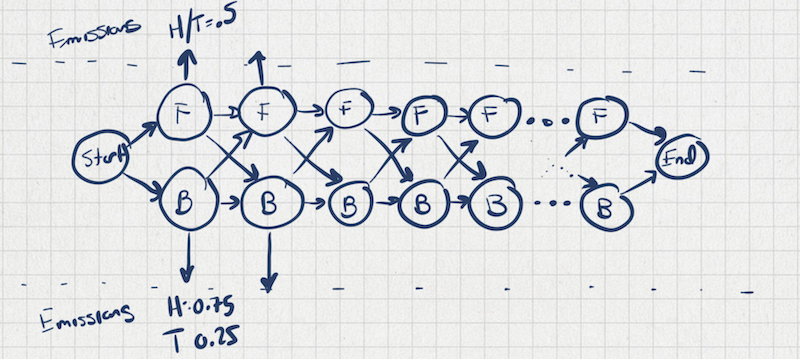

## Solve the decoding problem with the Viterbi algorithm

- We combine transitions and emissions into a _weight_ for each edge:

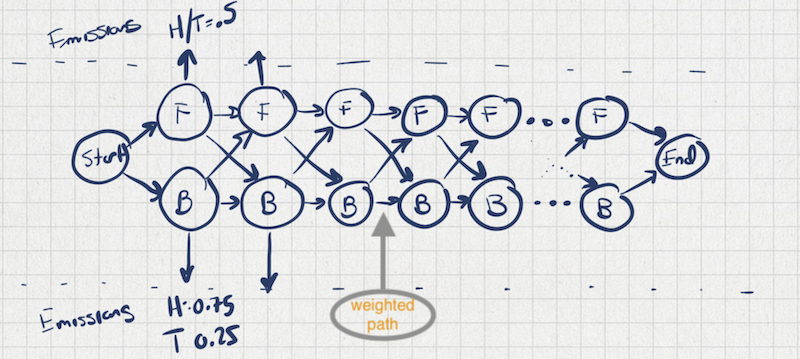

- This weight is the product of our emission and transition probabilties: $p(f_x | s_x) * p(s_{x-1} \text{ to } s_{x})$

## Some notes

- What are the weights of the __start__ to column 1?

- What are the weights of column n to __end__?



## Now actual Viterbi

For the biased coin cell highlighed below, we compute:
$
score(i,j) = \max
\begin{cases} 
      \pi_{i_\text{fair },j-1} * transition_{\text{(fair to biased)}} * emission_{\text{ H } | \text{biased}} \\
      \pi_{i_\text{biased },j-1} * transition_{\text{(biased to biased)}} * emission_{\text{ H } | \text{biased}} \\
\end{cases}
\\
$

For the fair coin cell directly __above__ the highlighed cell, we compute:

$
score(i,j) = \max
\begin{cases} 
      \pi_{i_\text{fair },j-1} * transition_{\text{(fair to fair)}} * emission_{\text{ H } | \text{fair}} \\
      \pi_{i_\text{biased },j-1} * transition_{\text{(biased to fair)}} * emission_{\text{ H } | \text{fair}} \\
\end{cases}
\\
$


## What does this look like?

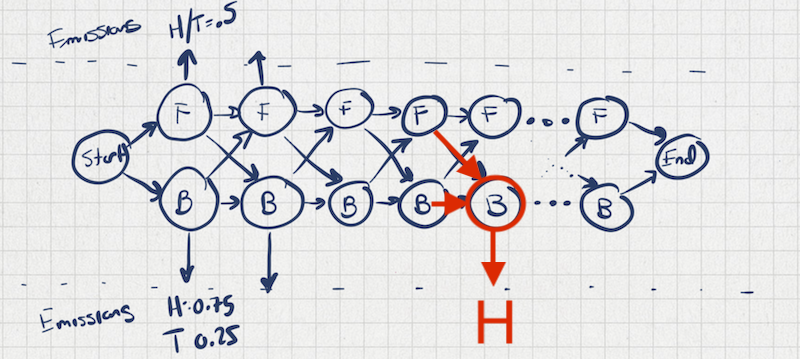


## Ok lets make this more practical (or at least domain specific)

### Lets try to find CpG islands in the human genome:

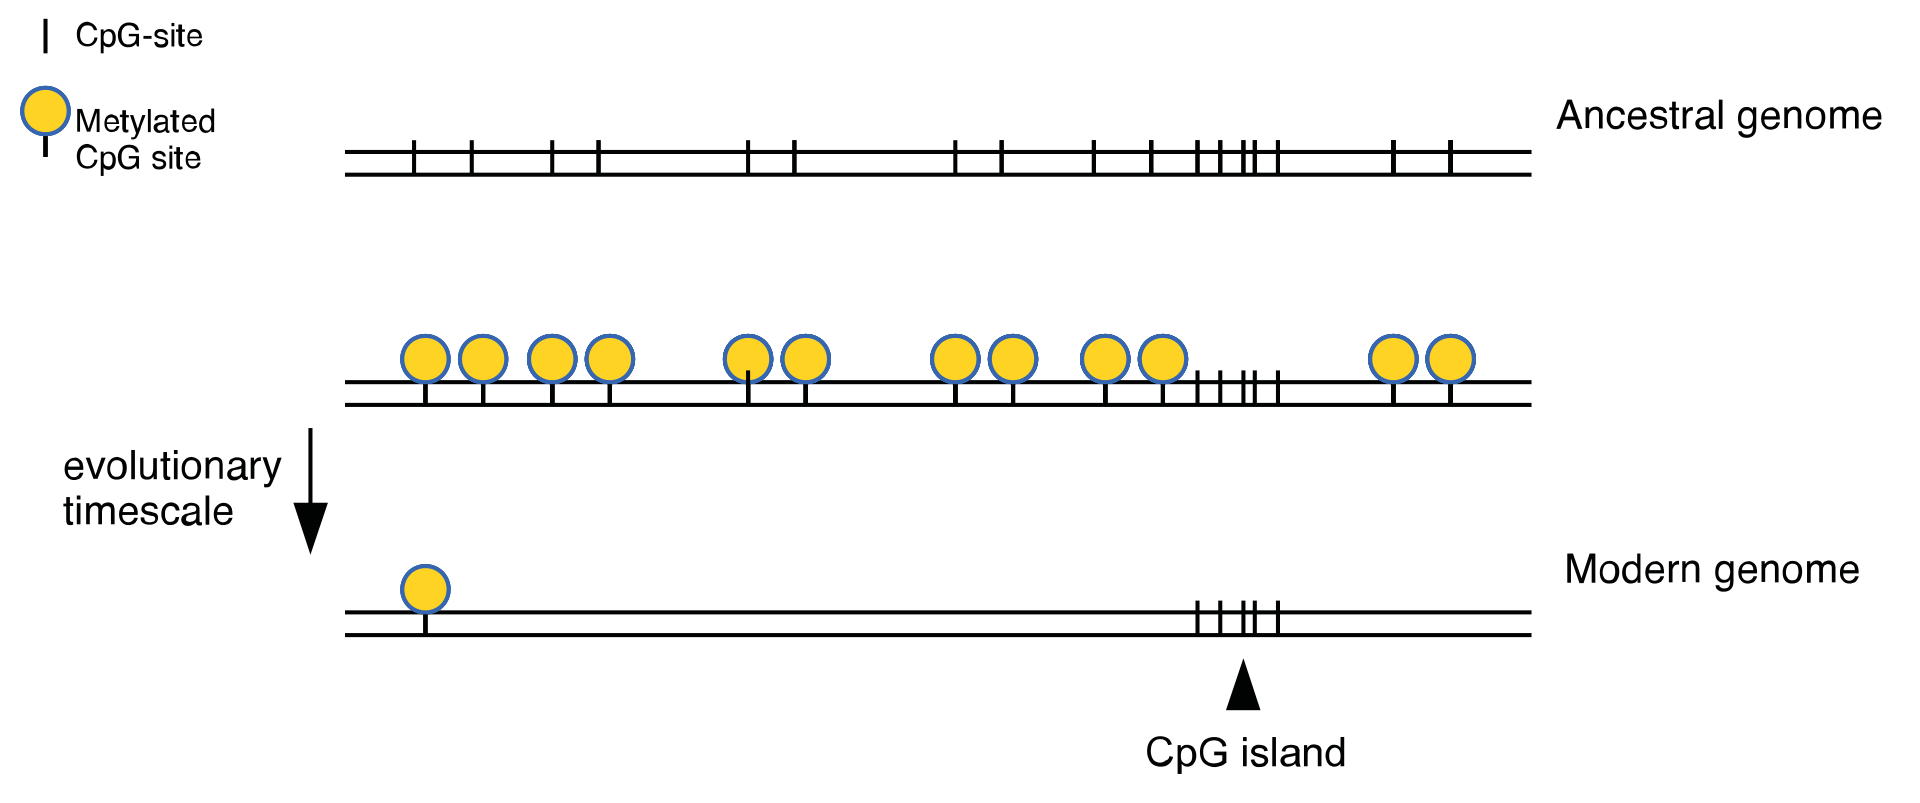

[Wikipedia](https://en.wikipedia.org/wiki/CpG_site#/media/File:Cpg_island_evolution.svg)


## Sliding window approach for CpG detection

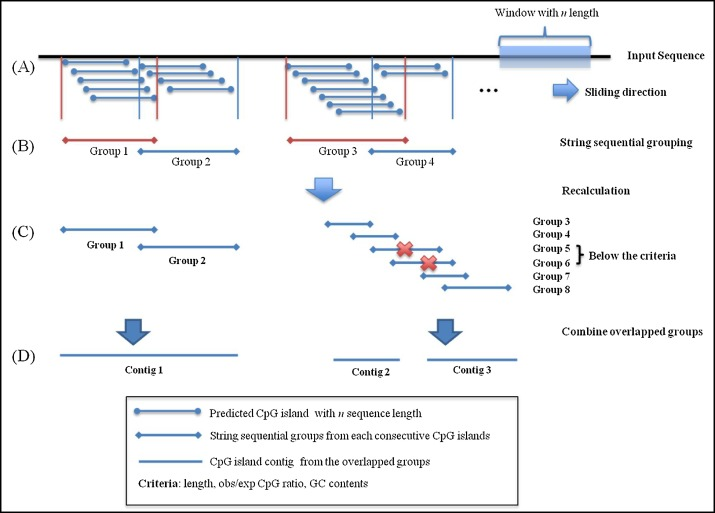

[Source](https://www.fsigenetics.com/article/S1872-4973(18)30101-7/fulltext)


## Fully probabilistic model for CpG island detection

- Fully variable window size

- Probabilistic, with calibrated scores for each candidate and a background model

- Able to infer parameters from training data

-  How do we start making such a model for CpG islands?

- Lets start simple: What's the dinucleotide composition of chromosome 21?



In [179]:
def pretty_print(seq_A, seq_B, dp_matrix,pad=6,round_to=3):
    '''
    This function does a lot of justification (ljust and print) to align the sequence and matrix
    We can copy-paste this into future code to help debug what our matrix is doing
    '''
    print("".join([letter_in_B.rjust(pad) for letter_in_B in seq_B]))

    for row_label, row in zip(seq_A, dp_matrix):
        print(row_label + "".join([str(round(mat_value,round_to)).rjust(pad) for mat_value in row]))


## Background distributions

- Lets use the A/C/G/T distribution in and out of CpG islands as our emissions

- Very simple, but as you'll see, it works suprizingly well (why?)


In [40]:
import gzip # use the gzip library in our project

chromosome_21_sequence = "" # this variable stores our chromsome 21 sequence

with gzip.open('chr21.fa.gz', 'rt') as chromosome_file: 
    header = chromosome_file.readline() 
    
    for line in chromosome_file:
        chromosome_21_sequence += line.strip()

# save ourselves a headache when we run into lower and uppercase letters
chromosome_21_sequence = chromosome_21_sequence.upper()

In [41]:
print(len(chromosome_21_sequence))

46709983


## Now lets see how dinucleotide proportions look across the chromosome:

In [67]:
import numpy as np

# a matrix of our emissions
emissions_global = np.zeros((5,5), np.int64)

# a function to convert a base to an array index
def base_to_index(base):
    if base == 'A':
        return 0
    elif base == 'C':
        return 1
    elif base == 'G':
        return 2
    elif base == 'T':
        return 3
    return 4 # catch all the other bases here

for index in range(0,len(chromosome_21_sequence) - 2):
    dinuc = chromosome_21_sequence[index:index + 2]
    index_1 = base_to_index(dinuc[0])
    index_2 = base_to_index(dinuc[1])
    emissions_global[index_1,index_2] += 1

## How dinucleotide proportions look across chromosome 21

In [260]:
pretty_print("ACGTN","ACGTN", emissions_global,10)

         A         C         G         T         N
A   3915117   2038442   2774777   3092310        18
C   2921760   2043408    462299   2757749        28
G   2420557   1705746   2062676   2037399         3
T   2563211   2397643   2926603   3968871         2
N        19         5        26         1   6621311


#### Normalize by total counts:

In [262]:
total_sum = emissions_global.sum() # axis=1
emissions_global_normalized = transitions / total_sum


## Do we see the effect of CpG -> TpG?

In [257]:
pretty_print("ACGTN","ACGTN", emissions_global_normalized)

     A     C     G     T     N
A 0.084 0.044 0.059 0.066   0.0
C 0.063 0.044  0.01 0.059   0.0
G 0.052 0.037 0.044 0.044   0.0
T 0.055 0.051 0.063 0.085   0.0
N   0.0   0.0   0.0   0.0 0.142


## What if we look at known CpG islands?

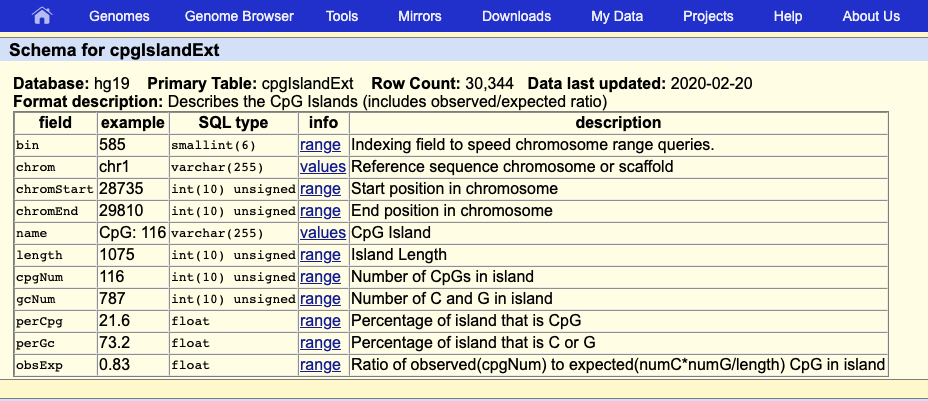

[Source](http://genome.ucsc.edu/cgi-bin/hgTables?hgta_doSchemaDb=hg19&hgta_doSchemaTable=cpgIslandExt)

## What if we look at known CpG islands?


In [258]:
## What if we look only at CpG islands?
cpg_only_emissions = np.zeros((5,5), np.int64)
cpg_pairs = []

with open("chr21_cpg_locations_ucsc.bed") as cpg_file:
    for line in cpg_file:
        start_position = int(line.split("\t")[1])
        end_position =   int(line.split("\t")[2])
        cpg_pairs.append([start_position,end_position])
        for index in range(start_position,end_position - 1):
            dinuc = chromosome_21_sequence[index:index + 2]
            index_1 = base_to_index(dinuc[0])
            index_2 = base_to_index(dinuc[1])
            cpg_only_emissions[index_1,index_2] += 1
            

## What if we look at known CpG islands?

In [259]:
total_sum = cpg_only_transitions.sum()
cpg_only_emissions_normalized = cpg_only_emissions / total_sum
pretty_print_alignment("ACGTN","ACGTN", cpg_only_emissions_normalized)

     A     C     G     T     N
A 0.025 0.042 0.059 0.017   0.0
C 0.054 0.126 0.101 0.062   0.0
G 0.052 0.117 0.121 0.046   0.0
T 0.012 0.057 0.057 0.031   0.0
N   0.0   0.0   0.0   0.0  0.02


## Lets find them ourselves! Let's create an HMM!



In [84]:
# lets simply our emissions -- (why? think about it a little...) 
per_base_cpg = cpg_only_emissions[0:4,0:4].sum(axis=1)/cpg_only_emissions[0:4,0:4].sum()
per_base_not = emissions_global[0:4,0:4].sum(axis=1)/emissions_global[0:4,0:4].sum()

print(per_base_cpg)
print(per_base_not)
# Another question... what happens when you include Ns? why are the N props so different?

[0.14557031 0.35065711 0.34365213 0.16012045]
[0.29486326 0.20417831 0.20520508 0.29575334]


## Start with transition and emission matrices

- We can use emission probabilities
- This isn't perfect for a number of reasons...
- We're also cheating...
- So what about transition probabilities?



# Transition probabilities

- Intuition: how often (in nucleotides) do we think we'll want to switch underlying states? 
- Relatively how often do the states occur? 10% CpG islands? 50%? 99%?

In [202]:
transition_props = np.array([[0.9999,0.0001],[0.00001,0.99999]])
pretty_print("CN", "CN", transition_props,pad=8,round_to=5)

       C       N
C  0.9999  0.0001
N   1e-05 0.99999


## A quick aside before we start
 
- What's the probability of any one outcome?

$p(\text{cpg}_{x}) * p(G | \text{cpg}_{x}) * (\text{cpg}_{x-1}) * p(G | \text{cpg}_{x-1})  * (\text{cpg}_{x-2}) * p(G | \text{cpg}_{x-2}) * (\text{cpg}_{x-3}) * p(G | \text{cpg}_{x-3})  * (\text{cpg}_{x-4}) * p(G | \text{cpg}_{x-4}) ....$

- This gets really, really small, even for the most probable path

- We store numbers in log-space instead, where our multiplication becomes addition

- We can just log all the values ahead of time to save time.

- We just then have to be careful about zeros. See Durbin 3.6 for more helpful info on numerical stability

# Log and get ready!



In [203]:
per_base_cpg_log = np.log10(per_base_cpg)
per_base_not_log = np.log10(per_base_not)
print(per_base_cpg_log)
print(per_base_not_log)

[-0.83692719 -0.45511735 -0.46388096 -0.79555321]
[-0.53037933 -0.6899904  -0.68781188 -0.52907034]


In [221]:
transition_log = np.log10(transition_props)
print(transition_log)

[[-4.34316198e-05 -4.00000000e+00]
 [-5.00000000e+00 -4.34296653e-06]]


In [214]:
# lets keep it light and breezy, and do just 9M-10M of Chr21...
chr21_9m_to_10m = chromosome_21_sequence[9000000:10000000]

# clean out any non ACGT bases
chr21_9m_to_10m = [x if x in "ACGT" else np.random.choice(["A","C","G","T"]) for x in chr21_9m_to_10m]

# a 2 row X 1M row matrix - we'll 
hmm_model = np.ones((2,len(chr21_9m_to_10m)))
hmm_model_traceaback = np.ones((2,len(chr21_9m_to_10m)),np.int64)

print(hmm_model.shape)

(2, 1000000)


## setup the first column

- The first column is the transition from the start to each state

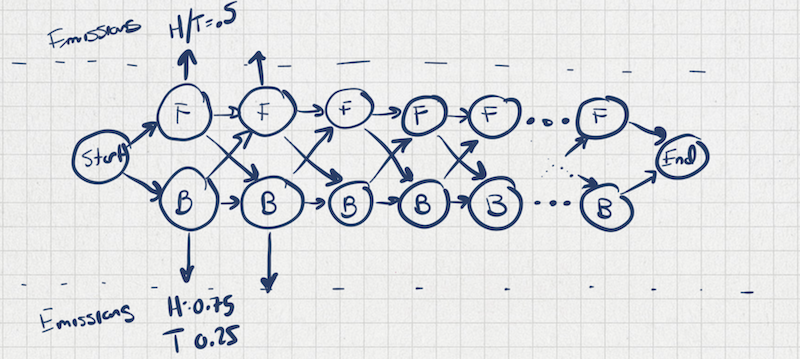

## setup the first column

- The first column is the transition from the start to each state


In [215]:
# some assumed probabilities
hmm_model[0,0] = np.log10([0.1]) + per_base_cpg_log[base_to_index(chr21_9m_to_10m[0])]
hmm_model[1,0] = np.log10([0.9]) + per_base_not_log[base_to_index(chr21_9m_to_10m[0])]

# we're coming from the non-CPG state
hmm_model_traceaback[0,0] = 1
hmm_model_traceaback[1,0] = 1

In [216]:
print(hmm_model[0,0])
print(hmm_model[1,0])

-1.7955532072040912
-0.5748278283319367


In [217]:
print(hmm_model_traceaback[0,0])
print(hmm_model_traceaback[1,0])

1
1


In [124]:
# what's a higher probability?

## Fill in the rest of the matrix

In [218]:
%timeit

for i in range(1,len(chr21_9m_to_10m)):
    cpg_emission     = per_base_cpg_log[base_to_index(chr21_9m_to_10m[i])]
    not_cpg_emission = per_base_not_log[base_to_index(chr21_9m_to_10m[i])]
    
    transition_cost_to_cpg     = # maximum 'weight' connection to CpG
    
    transition_cost_to_non_cpg = # maximum 'weight' connection to non CpG

    
    hmm_model[0,i] = transition_cost_to_cpg     + cpg_emission
    hmm_model[1,i] = transition_cost_to_non_cpg + not_cpg_emission
    
    hmm_model_traceaback[0,i] = # maximum 'weight' connection to CpG
    
    hmm_model_traceaback[1,i] = # maximum 'weight' connection to non CpG

## What has our model produced?

In [264]:
print(hmm_model[0,-5:])
print(hmm_model[1,-5:])


[-596232.83277297 -596233.62836961 -596234.06060601 -596234.85620265
 -596235.2687333 ]
[-596229.06765037 -596229.59672505 -596230.28454127 -596230.81361595
 -596231.50361069]


In [265]:
print(hmm_model_traceaback[0,-5:])
print(hmm_model_traceaback[1,-5:])

[1 0 1 0 1]
[1 1 1 1 1]


# What have we done...

- Filled in the full matrix probability of the most likely path 

- Filled in a traceback matrix with values we can use to extract the CpG hidden states and probability

## Next time 

- Traceback the state

- What's the probability? Vs what?

- What if we don't know these parameters? (transisitions for example)

## Logistics

- HW6 out today, due Monday

- That's the end of homeworks